<a href="https://colab.research.google.com/github/trashpanda900/Data-Science/blob/main/Copy_of_Unit4NotesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm

#Unit 4: Hierachical Models

In this unit we will cover how to model data containing sepreate, but related, groups. We'll start with a continuous data example; here's how we'll break it down. We will:

1. Make a model and assume that the groups are unrelated, or *independent*
2. Alter that model by changing our assumption so that the groups are related, or have some amount of *dependence*
3. Compare and contrast those models using a plot.
4. Cover the same concept with a discrete data set, introducing some complexities and problems with creating groups

Let's get started.

### Loading and Visualizing our Data

The below chemical shift data set is different from that used previous unit; it contains theoreitcal and experimental chemical shift values for 19 different amino acids. Let's view the raw data to see what I mean.

In [ ]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [ ]:
#print a the begining and end of the raw data set, as a pandas dataframe
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


We are interested in only three columns (variables) for now:
- aa, which stands for amino acid
- theo, which is the theoretical chemical shift value, calculated using "quantum methods", to quote our textbook.
- exp, which is the observed chemical shift value from Nuclear Magnetic Reasonance (NMR)

The following two plots help visualize the theoriteical values for each protein, and the experimental values for each protein.

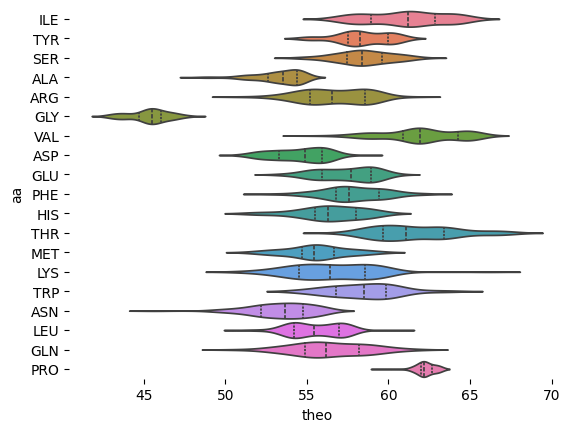

In [ ]:
#visualize theoretical chem shift values for all the amino acids
sns.violinplot(cs_data, x='theo', y='aa', inner='quart',hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

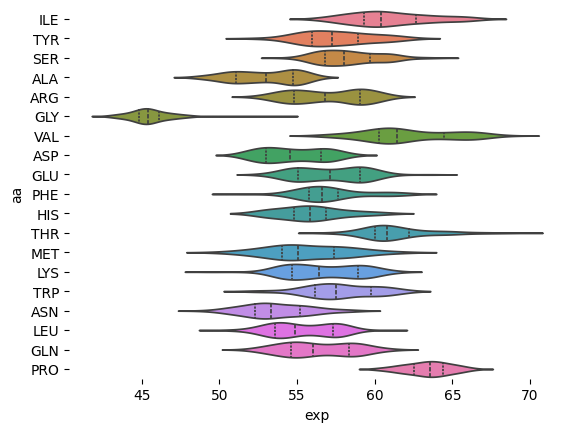

In [ ]:
#visualize experimental chem shift values for all the amino acids
sns.violinplot(cs_data, x='exp', y='aa', inner='quart', hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True)

**Task1**:

Without building a model, answer the following:

For each amino acid, are the theoretical chemical shift values different from
the experimental values?
They look pretty similar

### A Light Foray into Causality

The visualization method I will show you in this section will be either our first or second step going forward (plotting the raw data, as we did, or making a causal diagram, as we will do, are both valid first steps).

I will use graphviz to make a directed acyclic graph (DAG) that maps out how we will combine the theoretical and experimental chemical shift values.

Note that I will call most DAGs "causal graphs" or "causal diagrams", since we will exclusively use them to make statements about what causes what.

In [ ]:
dag_cs = gv.Digraph(comment='cs_dag') #cs for chemical shift

dag_cs.node('E', 'Experimental chem shift')
dag_cs.node('T','Theoretical chem shift')
dag_cs.node('D','Difference between experimental and theoretical')
#dag_cs.node('A','Amino Acid Type')

dag_cs.edges(['ED','TD', ])

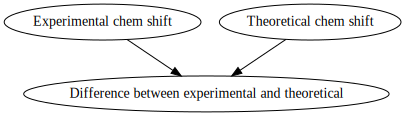

In [ ]:
dag_cs

Now for some vocabulary:

- Nodes (the ovals) represent variables, or columns in a data frame.
- Edges (the arrows) represent morphisms, or functions from one node to another
- The direction of the arrow tells the viewer that one node has some causal effect on the other node.

The graph above reads: "Experimental chem shift and Theoretical chem shift independently cause the Difference between them."

- Independent means that two node have no directed path between them. In other words we cannot get from one node to the other without having to "go backwards" on an arrow. That's an oversimplification; we'll get more nuanced in a later unit.

Most of the time, our causal graphs will be a big pile of assumptions. We'll then use models to provide evidence for and agaisnt those assumptions.

This first causal diagram is an exception though: "Experimental chem shift and Theoretical chem shift independently cause the Difference between them," because we are literally subtracting the numbers in column ```theo``` by the numbers in coumn ```exp```--, as in ```cs_data.theo - cs_data.exp```.

Why all the fuss about causal diagrams then, if all we are doing is subtracting?

I promised that would need the ```aa``` column, or the amino acid type variable. Putting that into our diagram will help us understand our pymc models later.

### Transforming Data to Match Causal Assumptions

Here's code to find the raw difference between the theoretical and expermental chemical shift values within each amino acid, and to store that difference in our data.

In [ ]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
#print the dataframe with the new column
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


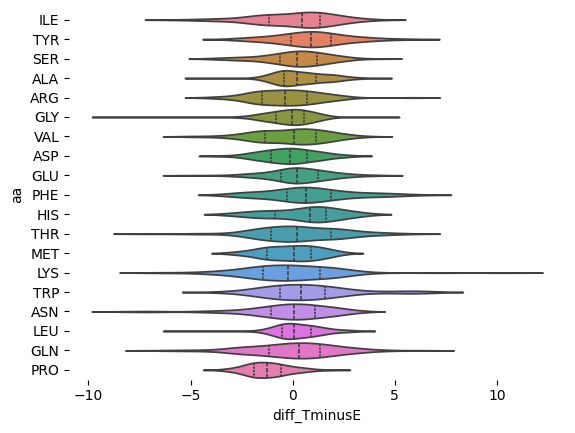

In [ ]:
#visualize difference in chem shift values for all the amino acids
sns.violinplot(cs_data, x='diff_TminusE', y='aa', inner='quart',hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

**Task2**:

Using the graph of raw differences, answer the following:

- For each amino acid, are the theoretical chemical shift values different from
the experimental values?
They are all centered around zero so no.
- If you had to use one likelihood to model the chemical shift for each amino acid, which one would you use?
Moderate since they are all centered

Visualizing the raw data and making a guess from it is neccessary, but not sufficient. Was does that mean? We have, at this point, got to the start line.

We understand the information we have as well as we can, and we've used our knowldge to make a preliminary guess: we think the difference between the theoretical chemical shift values and the experimental chemical shift values is around zero. In other words, **we think the "quantum methods" more or less predict the actual chemical shift values in the 19 amino acids we looked at.**

Its the "more or less" part in the last statement that our model will boslter. In the simple models from these first 5 units, its often possible to visualize the raw data like we did and come to a reasonable conclusion. Our models, right now, confirm or deny our intuition, and also give us a mathematical way of saying how confident we should be in our conclusion.

In later units, with more complicated data and goals, our models will end up being the best summarization method. But we should always try to make visualizations without our models first, as we did here.


In order to make a model for the differences between the chemical shift values for each amino acid--and thus confirm our hypothesis--, we need a to give our model a way to know which difference corresponds to which amino acid. The next few code blocks do this.

In [ ]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [ ]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [ ]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

**Task3:**

Describe what  ```aa_coords``` and ```aaidx``` are, and why they might be useful.
They asign numbers to the different codes

Now that we've set up our data, let's talk priors and likelihood.

 We'll make the assumption that all our priors, and our likelihood, are normal/halfnormal. This is for two reasons:
- To keep things simple while we explore hierarchical models; we'll think harded about our likelihood and prior(s) later.
- If all we know about our data is that there is an expected value and variation around that value, then its distribution will be normal. This often a good assumption to start our model building process with.

##Continuous Data, Independent Groups

Our data is grouped into 19 different amino acids. To start, I'll assume that knowing somwthing about one amino acid provides 0 information about any of the other amino acids. We call this "assuming independence", and like all assumptions, we should interrogate it. Our method of interrogation will be to make an additional model that assumes the amino acids are dependent.

**Task4**:

Do you think amino acids are independent from one another, with respect to chemical shift and quantum methods?
Yes?

Let's see the code for the model where we assume each amino acid is independent from one another.

Note that I'm using the differences between the experimental and theoretical chem shift values as my data

In [ ]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()

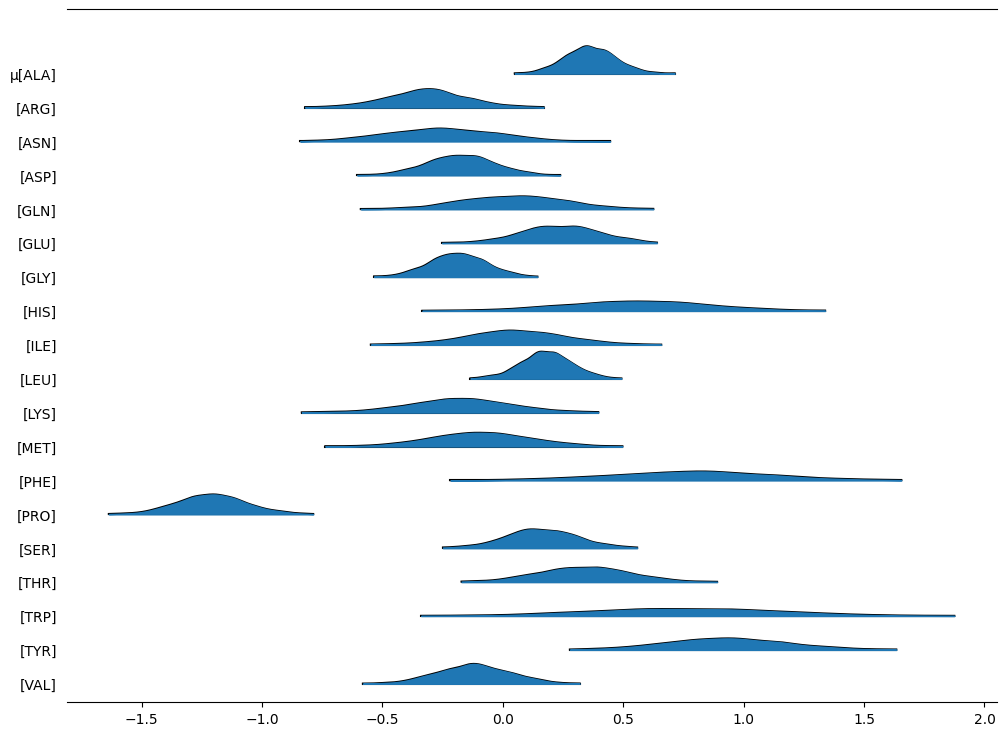

In [ ]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_cs_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task5:**

What's the probability of a chem shift difference landing in any of the blue regions, acoording to our model?
98%
Why that percentage chance? Where did it come from?

**Task6**:

Using cs_nh_model and the visualization of its posteriors above, answer the following:

Is there a difference between the theoretical and experimental chemical shift values in the amino acids from cs_data?
Yes

## Continuous Data, some Dependence among Groups

The model we made and any conclusions we can reach from it are only as good as our assumptions, and we assumed that using one amino acid to predict another was foolish.

We will now relax that assumption, and build a model that automatically uses information about the mean chemical shift of one amino acid to predict the mean of another.

By what black magic is this possible? Before answering that question, and I'll ask you a different question.

### Group Dependence in a Causal Diagram

Let's make a causal diagram to see what I mean.

First, here's the DAG for the independent model we just did

In [ ]:
dag_cs = gv.Digraph(comment='cs_dag') #cs for chemical shift

dag_cs.node('E', 'Experimental chem shift')
dag_cs.node('T','Theoretical chem shift')
dag_cs.node('D','Difference between experimental and theoretical')
#dag_cs.node('A','Amino Acid Type')

dag_cs.edges(['ED','TD', ])

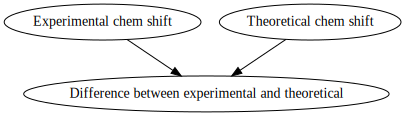

In [ ]:
dag_cs

And here's one where we include amino acid information and group (total, or global) effect information:

In [ ]:
dag_cs_aa = gv.Digraph(comment='cs_dag') #cs for chemical shift, aa for amino acid

dag_cs_aa.node('E', 'Experimental chem shift')
dag_cs_aa.node('T','Theoretical chem shift')
dag_cs_aa.node('D','Difference between experimental and theoretical')
dag_cs_aa.node('A','Amino Acid Type')
dag_cs_aa.node('G', 'Group Effect')

dag_cs_aa.edges(['AE','AT','AD','ED','TD', 'GA',])

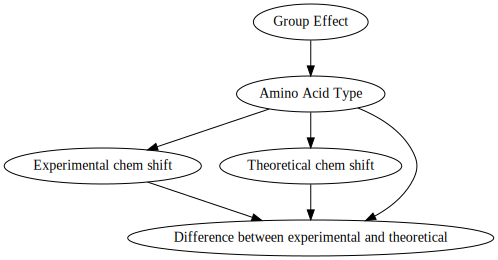

In [ ]:
dag_cs_aa

Because we are doing simple subtraction between Experimental chem shift and Theoretical chem shift, we can use the following, simpler diagram instead.

In [ ]:
dag_cs_aa = gv.Digraph(comment='cs_dag') #cs for chemical shift, aa for amino acid

dag_cs_aa.node('D','Difference between experimental and theoretical')
dag_cs_aa.node('A','Amino Acid Type')
dag_cs_aa.node('G', 'Group Effect')

dag_cs_aa.edges(['AD','GA', ])

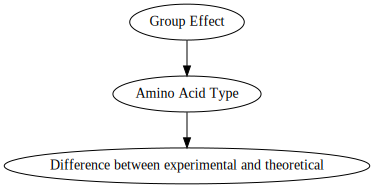

In [ ]:
dag_cs_aa

Now to explain what I mean by "Group Effect".

We want our model, when its predicting a chem shift difference for a specific amino acid, to "listen" to all the other amino acid differences.

One way to "listen" is to include information on the average, or mean, difference for amino acids in general, and then let that influnce how we find the difference for a specific amino acid.

Our group effect will thus be the overall mean.

#### A Brief Foray into Algebra Land

Before we actually make a model that admits that knowing about one amino acid let's us predict another, we will take a detour to explore what exactly is going on algebraiclly.


Recall the algebraic definition of a posterior distribution?

Well, here it is anyway: $p(\theta | y) ∝ p(y|\theta)p(\theta)$

Vocab review:
- $θ$ is parameter we want to predict; in the chem shift example, its the difference in theo and exp chem shift within each amino acid.
- y is our data; in the chem shift example, this is the differences in teh theo and exp chem shifts
- ∝ reads "proportional to". We avoid saying "=" so we can avoid $p(y)$, which is usually a nasty integral.

That basic formula is still (more or less) what we're using for the independent model that we've already made.

What about the dependent setting, with the group effect included?

In that setting, the difference within each amino acid (θ) is affected by the overal difference from all the amino acids. We will label the global difference, the difference between theo and exp chem shift for all amino acids, as ϕ

It's inclusion changes are formula to be thus:

$p(\theta,\phi|y)∝p(y|\theta,\phi)p(\theta,\phi)$

which expands to

$p(\theta,\phi|y)∝p(y|\theta,\phi)p(\theta|\phi)p(\phi)$

Will you ever need to know those formulas?

Nope, not in this class you won't.

The point of them is to show that if we want a group level effect, when tranlate that effect into a probability distribution, shove it in our model, and let our machine whirr.

**Task7**:

Now for a related question:

Can a prior have a prior?
Yes
If so, what would that do, and why would we ever want that?
To alter the prior

Here' how to use hyperpriors to let our knowledge of one amino acid's mean chemical shift affect anothers.

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

### Implementation of Group Level Effects

Let's (finally) make a model that admits that knowing about one amino acid changes our guess for another amino acid.

Here' how to use hyperpriors to let our knowledge of one amino acid's mean chemical shift affect anothers.

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

**Task8**:

Considering only the code for cs_h_model and cs_nh_model, write down similarities and differences.

Let's see what the hierarchical (dependent) model cs_h_model's posterior looks like, and compare it to the non-hierarchical (independent) model, cs_nh_model.

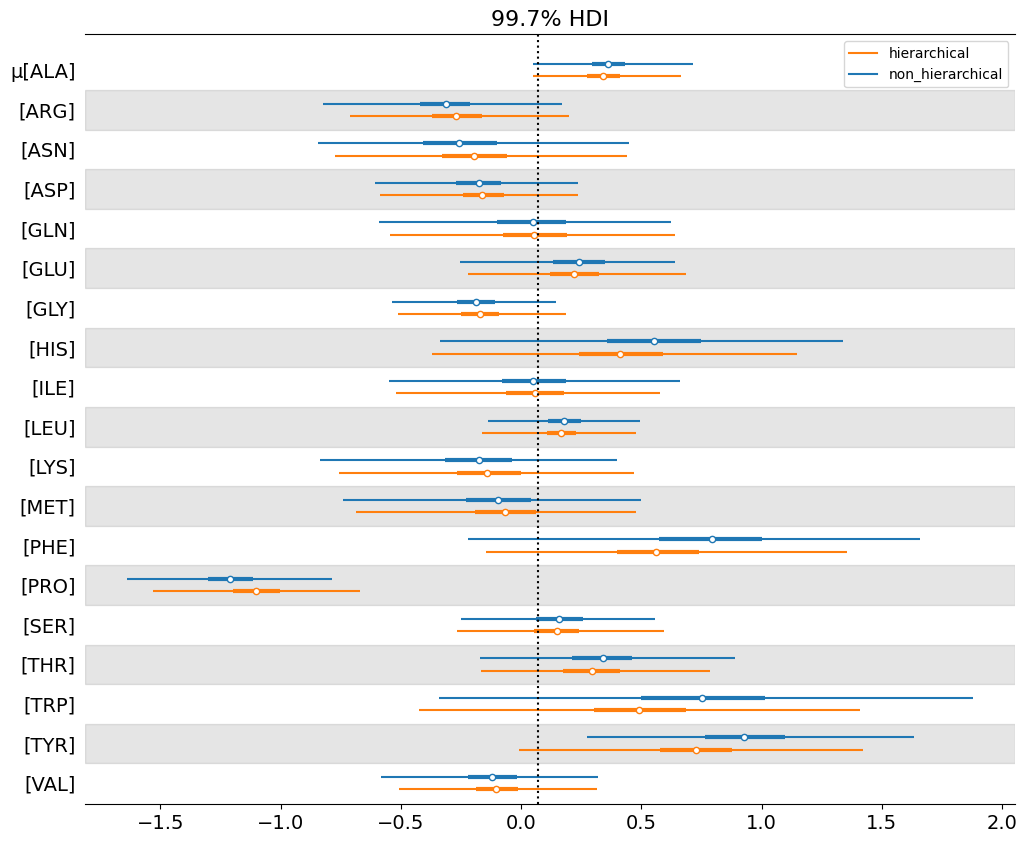

In [ ]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_nh, idata_cs_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task9**:

Focus on the white dots, which are the means of the posteriors. How did allowing our model to use one amino acid's chemical shift mean to predict another's change our our predictions?

In other words, how do the hierarchical (dependent) cs_h_model, and non-hierarchical (independent) cs_nh_model, differ?

#### Visualizing Model Structure

PyMC has its own built in model structure visualization tool. It's closely related to the causal diagrams I showed you earlier. In fact, if we wanted to, we could merge the two.

But before we do that, let's see the pymc visualizations.

Below are two visualizations, one of the non-hierarchical model, and one of the hierarchical model. Make sure to use:
```
pm.model_to_graphviz()
```
whenever you have a model more complicated than cs_nh_model

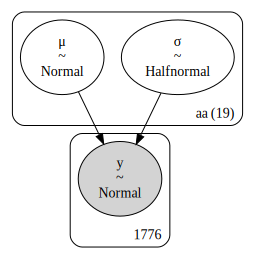

In [ ]:
pm.model_to_graphviz(cs_nh_model)

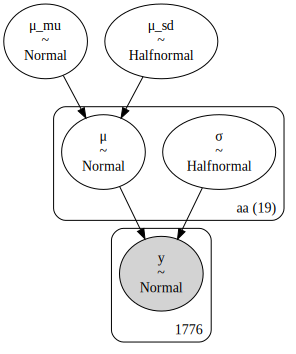

In [ ]:
#the hyper priors only affect μ, and they are not split up by aa, by amino acid.
pm.model_to_graphviz(cs_h_model)

Notice that there's no hyperpriors for $σ$; this means we assume that the variance of one amino acid is independent from variance of another.

The above visualizations focus on mapping out how the hyperpriors, prior, and likelihood connect.

We will now "turn" those graphs into causal diagrams

First let's look at the independent, non-hierarchical causal diagram

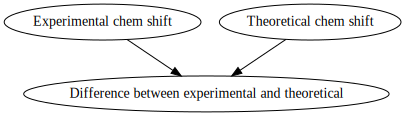

In [ ]:
dag_cs

We don't actually need to list experimental chem shift and theoretical chem shift, since they are inside the difference. So let's drop them.

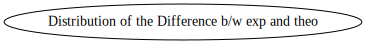

In [ ]:
dag_cs_nh = gv.Digraph(comment='cs_dag_nh') #cs for chemical shift, nh for nonhierarchical

#dag_cs.node('E', 'Experimental chem shift')
#dag_cs.node('T','Theoretical chem shift')
dag_cs_nh.node('D','Distribution of the Difference b/w exp and theo')
#dag_cs.node('A','Amino Acid Type')

#dag_cs.edges(['ED','TD', ])
dag_cs_nh

If all we want to visualize is how our data is connect, then this is it; the nonhierarchical model only has one column from the data frame in it, so it only has one node.

But note how I added "Distribution of" into the the title of the node.
This is what the pymc visualization focused on, and we'll add that information into our diagram

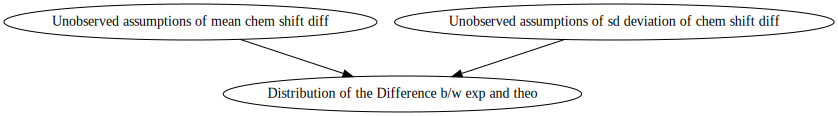

In [ ]:
dag_cs_nh = gv.Digraph(comment='cs_dag_nh') #cs for chemical shift, nh for nonhierarchical

dag_cs_nh.node('M', 'Unobserved assumptions of mean chem shift diff')
dag_cs_nh.node('S','Unobserved assumptions of sd deviation of chem shift diff')
dag_cs_nh.node('D','Distribution of the Difference b/w exp and theo')
#dag_cs.node('A','Amino Acid Type')

dag_cs_nh.edges(['MD','SD', ])
dag_cs_nh

I use the term "unobserved" to note that a variable does not come from data, but from my assumptions. Any variable that comes from my assumptions is a prior.

Now that we've altered our casual graph, it has an exact correspondence to pymc's visualization.

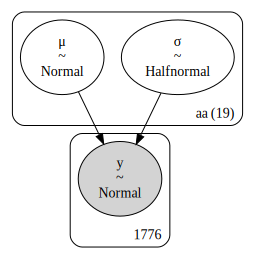

In [ ]:
pm.model_to_graphviz(cs_nh_model)

Let's do the same for now for the hierarchical, dependent model.

First, here's what it looked like before.

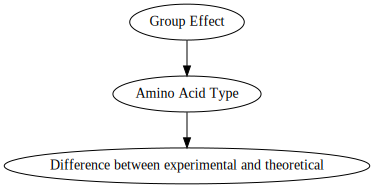

In [ ]:
dag_cs_aa

And we need it to look like this:

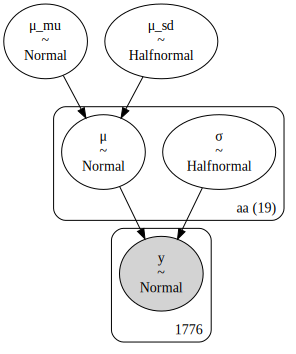

In [ ]:
#the hyper priors only affect μ, and they are not split up by aa, by amino acid.
pm.model_to_graphviz(cs_h_model)

Note that the casual diagram already has a three tiers, or hierarchies, just like the pymc graph.

**Task10:**

Make a new causal diagram that corresponds exactly to the pymc, distribution visualization.

Hints: There will be five total nodes, three of which will be "unobserved", and--this is new--one of which will be "partially observed"

## Discrete Data, Dependent Groups

For our discrete data set, we'll do another sports statistics example, but this time we'll cover soccer (football).

We'll also use a model that doesn't behave well with pymc, but we'll still trust its predictions. We'll dicuss why.

The following code will load the data in, and do the neccessary cleaning. Make sure you're reading my comments--I didn't write them just to help me.

In [ ]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

Look at the code below, focusing on the last two columns, goals and shots. This should remind you of the Wembanyama FT example, where we had makes and attempts.
Except there's 2681 players from the Premier League, Ligue 1, Bundesliga, Serie A, and La Liga, instead of 1 NBA player. There's also a categorical variable named position, and these data were complied from 2017-2020.

What's pertinent to use is that we'll use position the same way we used 'aa', amino acid, in the last example.

In [ ]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


**Task11**:

Plot goals and shots from sccr_data. I'd use a violin plot.

Then consider how you would select a prior for goals and shots.

Previously, we would have turned goals into an array of $1$s, and [shots - goals] into an array of $0$s. That worked great when we only cared about one player, and its still possible now, but it'd be nice if we could just shove 'goals' and 'shots' into our model as is.

And we can! But there's a price to paid for that decision, this time around . . .

Before we discuss that price, let's review how to get pymc to recognize the grouping we care about, soccer position.

In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

**Task12**:

Explain what the code block above is doing, and why we need to do it before running our pymc model. Make sure to reference the chemical shift amnio acid example.

Run the model below; this model takes about 6-8 minutes to run, and would likely have many divergences if I hadn't changed the target_accept parameter. I changed target_accept from the default of 0.8 to 0.95, based off our textbooks recommendation. Generally, if you can get your model to 0 divergences just based off changing target_accept, then its good enough.

That said, you should probably have some idea why pymc is throwing a fit before you try to press on without changing your model structure. In this case, the main problem is that goal keepers rarely shoot goals, so their shooting percentage is hard to predict.

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Below is a visualization of the markov chains that did our inference for us and generated our posterior. A healthy chain is tightly packed, with a steady amplitude.

Notice that μ_p and  ν_p each had an unheathly chain, but that its other chains weren't so bad.
These are the chains for goals and shots for the Goal Keeper (GK) postion; as we'll see below, the model had a hard time predicting GK. That hard time ended up making the chains for μ and ν a little wobbly, and made our prediction for θ more uncertain as well.

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

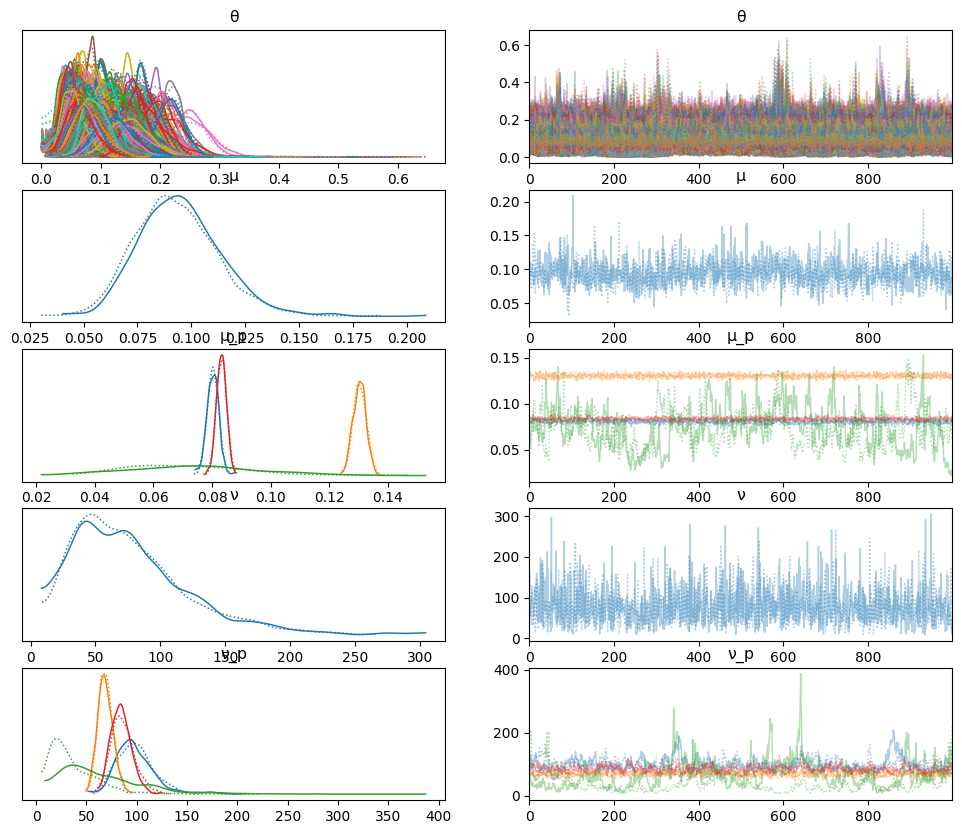

In [ ]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

The following code will give you something called $\hat{R}$ values (pronounced "r hat"); these are how I know the faulty chains are from the GK position.

All you need to know about $\hat{R}$ values is that values between 1 and 1.001 are good, and values above 1.1 are bad.


**Task13**:

Using the values from running rhat function on idata_sccr, explain how I was able to know that the GK group is the problem.

In [ ]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 0.9994 1.001 1.002 ... 1.001 1.001 1.001
    μ        float64 8B 1.002
    μ_p      (pos) float64 32B 1.007 1.002 1.004 1.0
    ν        float64 8B 0.9999
    ν_p      (pos) float64 32B 1.002 1.001 1.147 1.007

The following will plot the means for each position; you can see that the model has no idea what the shooting percentage (goals/shots) should be for GKs.

Its pretty confident about the other positions though, and its predictions seem to match reality. Forwards (FW) role on a scoccer team is to shoot goals, so it makes sense that they have a higher shooting precentage.

array([<Axes: >], dtype=object)

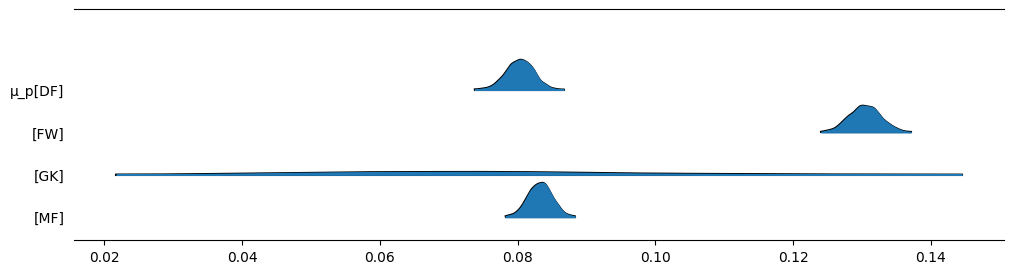

In [ ]:
# plots a 99.8% HDI for the positions shooting percentage means
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

As a final treat, here's a visualization of how Lionel Messi's shooting percentage compares to other FWs, and to other professional soccer players.

Text(0.5, 1.0, 'Messi mean')

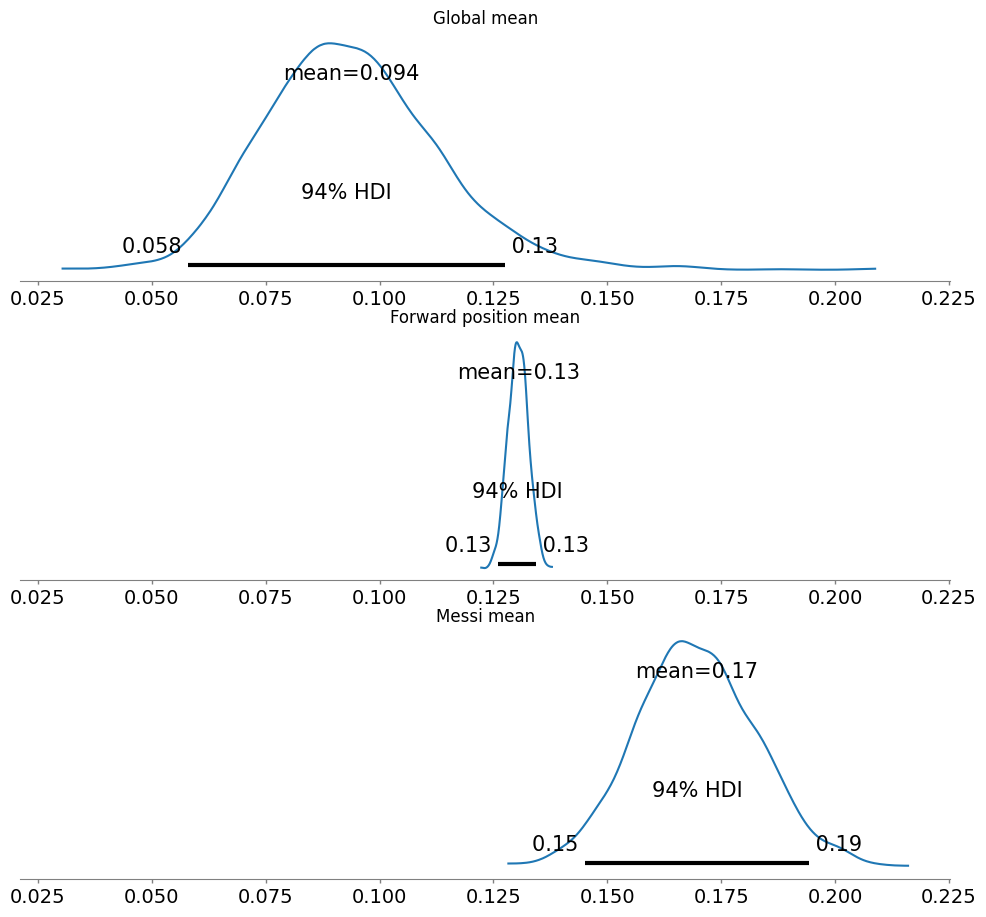

In [ ]:
#preps a plot object to have three seperate plots, all with the same x axis
_, ax = plt.subplots(3, 1, figsize=(12, 11), sharex=True)

#plot the overall mean shooting percentage
az.plot_posterior(idata_sccr, var_names='μ', ax=ax[0])
ax[0].set_title(r"Global mean")

#plot the fowrads shooting percentage
az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")

#plot Linonel Messi's shooting pecentage
az.plot_posterior(idata_sccr.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].set_title(r"Messi mean")

## Summary

This unit covered hierarchical models, and not only showed us that priors can have priors, but that these hyperpriors can be useful too.

All the models in this unit were more complicated than we've seen before, and they demanded that we study the structure of our raw data. To do this, we need two new graphical tools. One focused on how we linked the data together (casual diagrams), and one focused on how the distributions in our model are connected (pymc's visualization). By adding unobserved nodes to a causal diagram, we learned how to create a correspondence between the two.

Hyperpriors were used to allow sub groups within a data set to inform one another; we saw this with amino acids' chemical shift values pulling each other towards a common mean. This made us more likely to conclude that a given amino acid was well predicted by theoretical methods.

We then finished by creating a model for professional soccer player shooting percentage. This model introduced us to some new model checking tools, and helped us learn that breaking our data into subgroups can make pymc's job harder, even if these group labels reflect reality.


In this unit's project, you'll work on example similar to the soccer data set, so that you can get more familiar with breaking a data set into groups, and then assigning priors to those groups. With that, you'll have the foundation for how to encode most context and assumptions into a model.

